# Three Qubit Quantum Autoencoder

Adapted from https://github.com/lockwo/quantum_computation/blob/6d2c73ff9ac129478e82e8ddcfed41cdcd7b83b9/TFQ/QAE/quantum_autoencoder.py#L19

In [ ]:
!pip install cirq

In [ ]:
!pip install tensorflow==2.7.0

In [ ]:
!pip install tensorflow-quantum

In [ ]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [ ]:
import tensorflow_quantum as tfq
import cirq 
import sympy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from itertools import product
import math

In [ ]:
# Right now states are |0>L, |1>L and |+>L
def getValidTrainStates(qubits, refQubits):
    return [ #|0>L
            { 'circuit': [cirq.I(qubits[0]), cirq.I(qubits[1]), cirq.I(qubits[2])], 
              'refcircuit': [cirq.I(refQubits[0]), cirq.I(refQubits[1]), cirq.I(refQubits[2])] 
            }, 
            { 'circuit': [cirq.X(qubits[0]), cirq.I(qubits[1]), cirq.I(qubits[2])], 
              'refcircuit': [cirq.I(refQubits[0]), cirq.I(refQubits[1]), cirq.I(refQubits[2])] 
            }, 
            { 'circuit': [cirq.I(qubits[0]), cirq.X(qubits[1]), cirq.I(qubits[2])],
              'refcircuit': [cirq.I(refQubits[0]), cirq.I(refQubits[1]), cirq.I(refQubits[2])] 
            },
            { 'circuit': [cirq.I(qubits[0]), cirq.I(qubits[1]), cirq.X(qubits[2])],
              'refcircuit': [cirq.I(refQubits[0]), cirq.I(refQubits[1]), cirq.I(refQubits[2])] 
            },
            # |1>L
            { 'circuit': [cirq.X(qubits[0]), cirq.X(qubits[1]), cirq.X(qubits[2])],
              'refcircuit': [cirq.X(refQubits[0]), cirq.X(refQubits[1]), cirq.X(refQubits[2])] 
            },
            { 'circuit': [cirq.I(qubits[0]), cirq.X(qubits[1]), cirq.X(qubits[2])], 
              'refcircuit': [cirq.X(refQubits[0]), cirq.X(refQubits[1]), cirq.X(refQubits[2])]
            },
            { 'circuit': [cirq.X(qubits[0]), cirq.I(qubits[1]), cirq.X(qubits[2])], 
              'refcircuit': [cirq.X(refQubits[0]), cirq.X(refQubits[1]), cirq.X(refQubits[2])]
            },
            { 'circuit': [cirq.X(qubits[0]), cirq.X(qubits[1]), cirq.I(qubits[2])], 
             'refcircuit': [cirq.X(refQubits[0]), cirq.X(refQubits[1]), cirq.X(refQubits[2])]
            },
            #|+>L
            { 'circuit': [cirq.H(qubits[0]), cirq.CNOT(qubits[0], qubits[1]), cirq.CNOT(qubits[1], qubits[2])], 
              'refcircuit': [cirq.H(qubits[0]), cirq.CNOT(qubits[0], qubits[1]), cirq.CNOT(qubits[1], qubits[2])]
            },
          ] 

def getValidTestStates(qubits, refQubits):
    return [ #|0>L
            { 'circuit': [cirq.I(qubits[0]), cirq.I(qubits[1]), cirq.I(qubits[2])], 
              'refcircuit': [cirq.I(refQubits[0]), cirq.I(refQubits[1]), cirq.I(refQubits[2])] 
            }, 
            { 'circuit': [cirq.X(qubits[0]), cirq.I(qubits[1]), cirq.I(qubits[2])], 
              'refcircuit': [cirq.I(refQubits[0]), cirq.I(refQubits[1]), cirq.I(refQubits[2])] 
            }, 
            { 'circuit': [cirq.I(qubits[0]), cirq.X(qubits[1]), cirq.I(qubits[2])],
              'refcircuit': [cirq.I(refQubits[0]), cirq.I(refQubits[1]), cirq.I(refQubits[2])] 
            },
            { 'circuit': [cirq.I(qubits[0]), cirq.I(qubits[1]), cirq.X(qubits[2])],
              'refcircuit': [cirq.I(refQubits[0]), cirq.I(refQubits[1]), cirq.I(refQubits[2])] 
            },
            # |1>L
            { 'circuit': [cirq.X(qubits[0]), cirq.X(qubits[1]), cirq.X(qubits[2])],
              'refcircuit': [cirq.X(refQubits[0]), cirq.X(refQubits[1]), cirq.X(refQubits[2])] 
            },
            { 'circuit': [cirq.I(qubits[0]), cirq.X(qubits[1]), cirq.X(qubits[2])], 
              'refcircuit': [cirq.X(refQubits[0]), cirq.X(refQubits[1]), cirq.X(refQubits[2])]
            },
            { 'circuit': [cirq.X(qubits[0]), cirq.I(qubits[1]), cirq.X(qubits[2])], 
              'refcircuit': [cirq.X(refQubits[0]), cirq.X(refQubits[1]), cirq.X(refQubits[2])]
            },
            { 'circuit': [cirq.X(qubits[0]), cirq.X(qubits[1]), cirq.I(qubits[2])], 
             'refcircuit': [cirq.X(refQubits[0]), cirq.X(refQubits[1]), cirq.X(refQubits[2])]
            },
            #|+>L
            { 'circuit': [cirq.H(qubits[0]), cirq.CNOT(qubits[0], qubits[1]), cirq.CNOT(qubits[1], qubits[2])], 
              'refcircuit': [cirq.H(qubits[0]), cirq.CNOT(qubits[0], qubits[1]), cirq.CNOT(qubits[1], qubits[2])]
            },
          ] 

def generate_data(qubits, refQubits, numOfTrain, numOfTest):
    """Generate training and testing data."""
    validTrainStates = getValidTrainStates(qubits, refQubits)
    validTestStates = getValidTestStates(qubits, refQubits)
    trainStates = []
    testStates = []
    rng = np.random.default_rng()
    
    for n in range(numOfTrain):
      circuit = cirq.Circuit()
      refCircuit = cirq.Circuit()
      indx = rng.integers(0, len(validTrainStates), size=1)[0]
      theState = validTrainStates[indx]['circuit']
      theRef = validTrainStates[indx]['refcircuit']
      for op in theState:
        circuit.append(op)
      for refOp in theRef:
        refCircuit.append(refOp)
      trainStates.append(circuit + refCircuit)
 
    for n in range(numOfTest):
      circuit = cirq.Circuit()
      refCircuit = cirq.Circuit()
      indx = rng.integers(0, len(validTestStates), size=1)[0]
      theState = validTestStates[indx]['circuit']
      theRef = validTestStates[indx]['refcircuit']
      for op in theState:
        circuit.append(op)
      for refOp in theRef:
        refCircuit.append(refOp)
      testStates.append(circuit + refCircuit)
 

    return trainStates, testStates

11
(0, 0): ─────────────────@────────Ry(q0)───Rz(q1)───────────────────────────────────────────────────────────────────────────────────────
                         │
(0, 1): ────────@────────X────────Ry(q2)───Rz(q3)───────────────────────────────────────────────────────────────────────────────────────
                │
(0, 2): ────@───X────────Ry(q4)───Rz(q5)────────────────────────────────────────────────────────────────────────────────────────────────
            │
(0, 3): ────X───Ry(q6)───Rz(q7)───────────────────────────────────@─────────Ry(q8)────Rz(q9)────────────────────────────────────────────
                                                                  │
(0, 4): ────────────────────────────────────────────────@─────────X─────────Ry(q10)───Rz(q11)───×───────────×───────────×───────────────
                                                        │                                       │           │           │
(0, 5): ────────────────────────────────────────────@───X──────

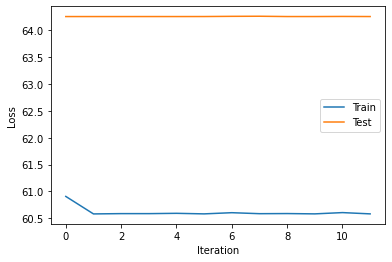

<Figure size 432x288 with 0 Axes>

In [ ]:
def layer(qs, params):
    circ = cirq.Circuit()
    for i in reversed(range(len(qs)-1)):
        circ += cirq.CNOT(qs[i], qs[i+1])
    for i in range(len(qs)):
        circ += cirq.ry(params[2*i]).on(qs[i])
        circ += cirq.rz(params[2*i + 1]).on(qs[i])
    return circ

def make_circuit(qs, state, params, depth, swap_qubit, reference_qubits):
    c = cirq.Circuit()
    enc_params = params[:len(params) // 2]
    dec_params = params[len(params) // 2:]
    numOfToParam = state+1
    for i in range(depth):
        c += layer(qs[:state+1], enc_params[2 * i * numOfToParam:2 * (i + 1) * numOfToParam])
    for i in range(depth):
        c += layer(qs[state:], dec_params[2 * i * numOfToParam:2 * (i + 1) * numOfToParam])
    # SWAP Test
    c += cirq.H(swap_qubit)
    for i, j in product(range(state), range(state+1, len(qs))):
        c += cirq.ControlledGate(sub_gate=cirq.SWAP, num_controls=1).on(swap_qubit, reference_qubits[i], qs[j])
    c += cirq.H(swap_qubit)
    return c

state_qubits = 3
ref_qubits = state_qubits
total_qubits = 7

qubits = [cirq.GridQubit(0, i) for i in range(total_qubits + 1 + ref_qubits)]
print(len(qubits))
train_circuits, test_circuits = generate_data(qubits[:state_qubits], qubits[total_qubits + 1:], 9000, 1000)
layers = 1

numberOfParamGates = 4
num_params = numberOfParamGates * (state_qubits+1) * layers
parameters = sympy.symbols("q0:%d"%num_params)
c = make_circuit(qubits[:total_qubits], state_qubits, parameters, layers, qubits[total_qubits], qubits[total_qubits + 1:])
print(c)
readout_operators = [cirq.Z(qubits[total_qubits])]
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
layer1 = tfq.layers.PQC(c, readout_operators, differentiator=tfq.differentiators.ForwardDifference())(inputs) # , differentiator=tfq.differentiators.Adjoint()
autoencoder = tf.keras.models.Model(inputs=inputs, outputs=layer1)
autoencoder.compile(loss='mape',optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

X_train = tfq.convert_to_tensor(train_circuits)
X_test = tfq.convert_to_tensor(test_circuits)

y_train = np.ones(shape=len(train_circuits))
y_test = np.ones(shape=len(test_circuits))

history = autoencoder.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), callbacks=[callback])

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()
plt.savefig("loss_comp")